Não esquece de fazer o download do Mega-Sena.xlsx no site:  blob:https://loterias.caixa.gov.br/14214295-f098-4a24-9cee-69fad8b98923
Depois faça o upload dele na pasta raiz do colab

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Carregar os dados
df = pd.read_excel('/content/Mega-Sena.xlsx')
colunas_bolas = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']
df_bolas = df[colunas_bolas].astype(int)

# Cria pares entrada -> saída (X -> Y)
X = []
y = []

for i in range(len(df_bolas) - 1):
    entrada = df_bolas.iloc[i].values
    saida = df_bolas.iloc[i+1].values
    X.append(entrada)
    y.append(saida)

X = np.array(X)
y = np.array(y)

# Divide treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normaliza os dados para [0,1]
X_train = X_train / 60.0
X_test = X_test / 60.0
y_train = y_train / 60.0
y_test = y_test / 60.0

# Modelo MLP simples
model = Sequential()
model.add(Dense(128, input_dim=6, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))  # saída com 6 números normalizados

model.compile(optimizer='adam', loss='mse')

# Treina
model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1)

# Faz previsão com o último sorteio
entrada_recente = df_bolas.iloc[-1].values / 60.0
pred = model.predict(np.array([entrada_recente]))[0]

# Converte de volta pro intervalo 1-60 e arredonda
palpite = np.round(pred * 60).astype(int)
palpite = np.clip(palpite, 1, 60)
palpite = np.sort(np.unique(palpite))  # remove repetidos e ordena

print(f"\n🎯 Palpite da IA para o próximo sorteio: {palpite}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0475
Epoch 2/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 3/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216
Epoch 4/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0214
Epoch 5/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 6/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215
Epoch 7/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0214
Epoch 8/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0212
Epoch 9/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0211
Epoch 10/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0215
Epoch 11/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0206
Epoch 12/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0213
Epoch 13/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0215
Epoch 14/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0212
Epoch 15/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Carrega os dados
df = pd.read_excel('/content/Mega-Sena.xlsx')
col_bolas = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6', 'Ganhadores 6 acertos']
df_bolas = df[col_bolas].astype(int)

# Define o tamanho da sequência (ex: usar últimos 20 sorteios como entrada)
seq_len = 20

# Prepara os dados de entrada e saída
X, y = [], []
for i in range(len(df_bolas) - seq_len - 1):
    # Adiciona a sequência das 6 bolas + o número de ganhadores como parâmetro de entrada
    sequencia_bolas = df_bolas.iloc[i:i+seq_len][['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']].values / 60.0  # Normaliza as bolas
    sequencia_ganhadores = df_bolas.iloc[i:i+seq_len][['Ganhadores 6 acertos']].values / df['Ganhadores 6 acertos'].max()  # Normaliza os ganhadores
    sequencia_completa = np.concatenate((sequencia_bolas, sequencia_ganhadores), axis=1)  # Combina bolas com ganhadores
    proximo_bolas = df_bolas.iloc[i+seq_len][['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']].values / 60.0  # Próximas bolas (a previsão)
    X.append(sequencia_completa)
    y.append(proximo_bolas)

X = np.array(X)  # shape: (amostras, 20, 7) - 6 bolas + 1 ganhadores
y = np.array(y)  # shape: (amostras, 6) - 6 bolas

# Define o modelo
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, 7), return_sequences=False))  # Agora com 7 características (6 bolas + 1 ganhadores)
model.add(Dropout(0.2))  # Dropout para evitar overfitting
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))  # Saída com 6 valores (6 bolas)

model.compile(optimizer='adam', loss='mse')

# Treinamento com EarlyStopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=200, batch_size=16, verbose=1, validation_split=0.2, callbacks=[early_stop])

# Previsão com os últimos sorteios
entrada = df_bolas.iloc[-seq_len:][['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']].values / 60.0  # Últimos sorteios (6 bolas normalizados)
entrada_ganhadores = df_bolas.iloc[-seq_len:][['Ganhadores 6 acertos']].values / df['Ganhadores 6 acertos'].max()  # Normaliza os ganhadores
entrada_completa = np.concatenate((entrada, entrada_ganhadores), axis=1)  # Combina as bolas com os ganhadores
entrada_completa = entrada_completa.reshape((1, seq_len, 7))  # Formato adequado para o modelo

# Faz a previsão
pred = model.predict(entrada_completa)[0]

# Converte a saída (as 6 bolas)
palpite_bolas = np.round(pred * 60).astype(int)  # Converte de volta para os números originais
palpite_bolas = np.clip(palpite_bolas, 1, 60)  # Garante que os números estão entre 1 e 60
palpite_bolas = np.sort(np.unique(palpite_bolas))[:6]  # Apenas os 6 números únicos

print(f"\n🔮 Palpite LSTM para o próximo sorteio: {palpite_bolas}")


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0293 - val_loss: 0.0207
Epoch 2/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0213 - val_loss: 0.0214
Epoch 3/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0215 - val_loss: 0.0204
Epoch 4/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0214 - val_loss: 0.0205
Epoch 5/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0225 - val_loss: 0.0205
Epoch 6/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0216 - val_loss: 0.0208
Epoch 7/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0218 - val_loss: 0.0205
Epoch 8/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0214 - val_loss: 0.0205
Epoch 9/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0211 - val_loss: 0.0205
Epoch 10/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0219 - val_loss: 0.0206
Epoch 11/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0217 - val_loss: 0.0205
Epoch 12/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 

In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Carrega os dados
df = pd.read_excel('/content/Mega-Sena.xlsx')
col_bolas = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6', 'Ganhadores 6 acertos']
df_bolas = df[col_bolas].astype(int)

# === Modelo 1: Baseado em ocorrências binárias ===

# Matriz de ocorrência binária (linhas = sorteios, colunas = dezenas 1 a 60)
ocorrencias = np.zeros((len(df_bolas), 60), dtype=int)
for i, row in df_bolas.iterrows():
    for num in row:
        ocorrencias[i, num - 1] = 1
df_ocorrencias = pd.DataFrame(ocorrencias, columns=[f'Dezena_{i+1}' for i in range(60)])

# Função para criar dados para o modelo baseado em ocorrências
def criar_dados_para_numero(numero, janela=10):
    vetor = df_ocorrencias[f'Dezena_{numero}'].values
    X, y = [], []
    for i in range(len(vetor) - janela):
        X.append(vetor[i:i+janela])
        y.append(vetor[i+janela])
    return np.array(X), np.array(y)

# Treinando os modelos para os números 1 a 10
modelos = {}
for num in range(1, 11):
    X, y = criar_dados_para_numero(num, janela=10)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=30, batch_size=8, verbose=0)

    modelos[num] = model

# === Modelo 2: Baseado em LSTM com bolas sorteadas e número de ganhadores ===

seq_len = 20

# Prepara os dados de entrada e saída
X, y = [], []
for i in range(len(df_bolas) - seq_len - 1):
    sequencia_bolas = df_bolas.iloc[i:i+seq_len][['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']].values / 60.0  # Normaliza as bolas
    sequencia_ganhadores = df_bolas.iloc[i:i+seq_len][['Ganhadores 6 acertos']].values / df['Ganhadores 6 acertos'].max()  # Normaliza os ganhadores
    sequencia_completa = np.concatenate((sequencia_bolas, sequencia_ganhadores), axis=1)  # Combina bolas com ganhadores
    proximo_bolas = df_bolas.iloc[i+seq_len][['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']].values / 60.0  # Próximas bolas (a previsão)
    X.append(sequencia_completa)
    y.append(proximo_bolas)

X = np.array(X)  # shape: (amostras, 20, 7) - 6 bolas + 1 ganhadores
y = np.array(y)  # shape: (amostras, 6) - 6 bolas

# Define o modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(128, input_shape=(seq_len, 7), return_sequences=False))  # Agora com 7 características (6 bolas + 1 ganhadores)
model_lstm.add(Dropout(0.2))  # Dropout para evitar overfitting
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(6, activation='sigmoid'))  # Saída com 6 valores (6 bolas)

model_lstm.compile(optimizer='adam', loss='mse')

# Treinamento com EarlyStopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_lstm.fit(X, y, epochs=200, batch_size=16, verbose=1, validation_split=0.2, callbacks=[early_stop])

# === Etapa 3: Combinação dos resultados dos dois modelos ===

# Pré-processamento para a predição do Modelo 1 (ocorrências binárias)
janela = 10
entrada_ocorrencias = df_ocorrencias.iloc[-janela:].values.T  # Últimos 10 sorteios, transpostos

# Previsão do Modelo 1
proximas_probabilidades_modelo_1 = {}
for num in range(1, 11):
    input_seq = entrada_ocorrencias[num - 1].reshape(1, -1)  # sequência do número X
    prob = modelos[num].predict(input_seq)[0][0]
    proximas_probabilidades_modelo_1[num] = prob

# Pré-processamento para a predição do Modelo 2 (LSTM)
entrada_bolas = df_bolas.iloc[-seq_len:][['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']].values / 60.0  # Últimos sorteios (6 bolas normalizados)
entrada_ganhadores = df_bolas.iloc[-seq_len:][['Ganhadores 6 acertos']].values / df['Ganhadores 6 acertos'].max()  # Normaliza os ganhadores
entrada_completa = np.concatenate((entrada_bolas, entrada_ganhadores), axis=1)  # Combina as bolas com os ganhadores
entrada_completa = entrada_completa.reshape((1, seq_len, 7))  # Formato adequado para o modelo

# Previsão do Modelo 2
pred_modelo_2 = model_lstm.predict(entrada_completa)[0]

# Converte as saídas do Modelo 2 (as 6 bolas)
palpite_bolas_modelo_2 = np.round(pred_modelo_2 * 60).astype(int)  # Converte de volta para os números originais
palpite_bolas_modelo_2 = np.clip(palpite_bolas_modelo_2, 1, 60)  # Garante que os números estão entre 1 e 60
palpite_bolas_modelo_2 = np.sort(np.unique(palpite_bolas_modelo_2))[:6]  # Apenas os 6 números únicos

# Combina as previsões de ambos os modelos
proximas_probabilidades_combinadas = {**proximas_probabilidades_modelo_1, **{num: prob for num, prob in zip(palpite_bolas_modelo_2, np.ones(len(palpite_bolas_modelo_2)))}}

# Mostra os 6 mais prováveis (dentre os 10 testados)
top_6_combinado = sorted(proximas_probabilidades_combinadas.items(), key=lambda x: x[1], reverse=True)[:6]
palpite_final = sorted([x[0] for x in top_6_combinado])

print(f"\n🔮 Palpite combinado (Modelo 1 + LSTM) para o próximo sorteio: {palpite_final}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0325 - val_loss: 0.0206
Epoch 2/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0222 - val_loss: 0.0204
Epoch 3/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0215 - val_loss: 0.0205
Epoch 4/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0210 - val_loss: 0.0207
Epoch 5/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0220 - val_loss: 0.0204
Epoch 6/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0213 - val_loss: 0.0208
Epoch 7/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0216 - val_loss: 0.0204
Epoch 8/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0216 - val_loss: 0.0208
Epoch 9/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0218 - val_loss: 0.0209
Epoch 10/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0214 - val_loss: 0.0205
Epoch 11/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0210 - val_loss: 0.0205
Epoch 12/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step

🔮 Palpite combinado (Modelo 1 + LSTM) para o próximo sorteio: [9, np.int64(18), np.int64(27), np.int64(36), np.int64(43), np.int64(52)]


In [ ]:
# Importações
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Carrega os dados
df = pd.read_excel('/content/Mega-Sena.xlsx')
col_bolas = ['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6', 'Ganhadores 6 acertos', 'Ganhadores 5 acertos']
df_bolas = df[col_bolas].astype(int)

# === LSTM ===
seq_len = 20
X, y = [], []

for i in range(len(df_bolas) - seq_len - 1):
    bolas = df_bolas.iloc[i:i+seq_len][['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']].values / 60.0
    g6 = df_bolas.iloc[i:i+seq_len][['Ganhadores 6 acertos']].values / df['Ganhadores 6 acertos'].max()
    g5 = df_bolas.iloc[i:i+seq_len][['Ganhadores 5 acertos']].values / df['Ganhadores 5 acertos'].max()

    # concatena bolas + g6 + g5
    sequencia = np.concatenate((bolas, g6, g5), axis=1)

    target = df_bolas.iloc[i+seq_len][['Bola1', 'Bola2', 'Bola3', 'Bola4', 'Bola5', 'Bola6']].values / 60.0
    X.append(sequencia)
    y.append(target)

X = np.array(X)
y = np.array(y)

# === Modelo LSTM ===
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, 8)))  # agora temos 8 features: 6 bolas + 2 ganhadores
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')

# Treinamento
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X, y, epochs=200, batch_size=16, verbose=1, validation_split=0.2, callbacks=[early_stop])

# === Previsão ===
entrada_bolas = df_bolas.iloc[-seq_len:][['Bola1','Bola2','Bola3','Bola4','Bola5','Bola6']].values / 60.0
entrada_g6 = df_bolas.iloc[-seq_len:][['Ganhadores 6 acertos']].values / df['Ganhadores 6 acertos'].max()
entrada_g5 = df_bolas.iloc[-seq_len:][['Ganhadores 5 acertos']].values / df['Ganhadores 5 acertos'].max()

entrada_modelo4 = np.concatenate((entrada_bolas, entrada_g6, entrada_g5), axis=1).reshape((1, seq_len, 8))
predicao = model.predict(entrada_modelo4)[0]

# Ajusta os palpites
palpite = np.round(predicao * 60).astype(int)
palpite = np.clip(palpite, 1, 60)
palpite = np.sort(np.unique(palpite))[:6]

print(f"\n🔮 Palpite (Modelo 4 - LSTM + Ganhadores 6 e 5 acertos): {palpite}")


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0310 - val_loss: 0.0218
Epoch 2/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0220 - val_loss: 0.0210
Epoch 3/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0210 - val_loss: 0.0209
Epoch 4/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0215 - val_loss: 0.0208
Epoch 5/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0217 - val_loss: 0.0206
Epoch 6/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0217 - val_loss: 0.0206
Epoch 7/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0219 - val_loss: 0.0208
Epoch 8/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0216 - val_loss: 0.0205
Epoch 9/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0208 - val_loss: 0.0206
Epoch 10/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0217 - val_loss: 0.0205
Epoch 11/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0214 - val_loss: 0.0212
Epoch 12/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 

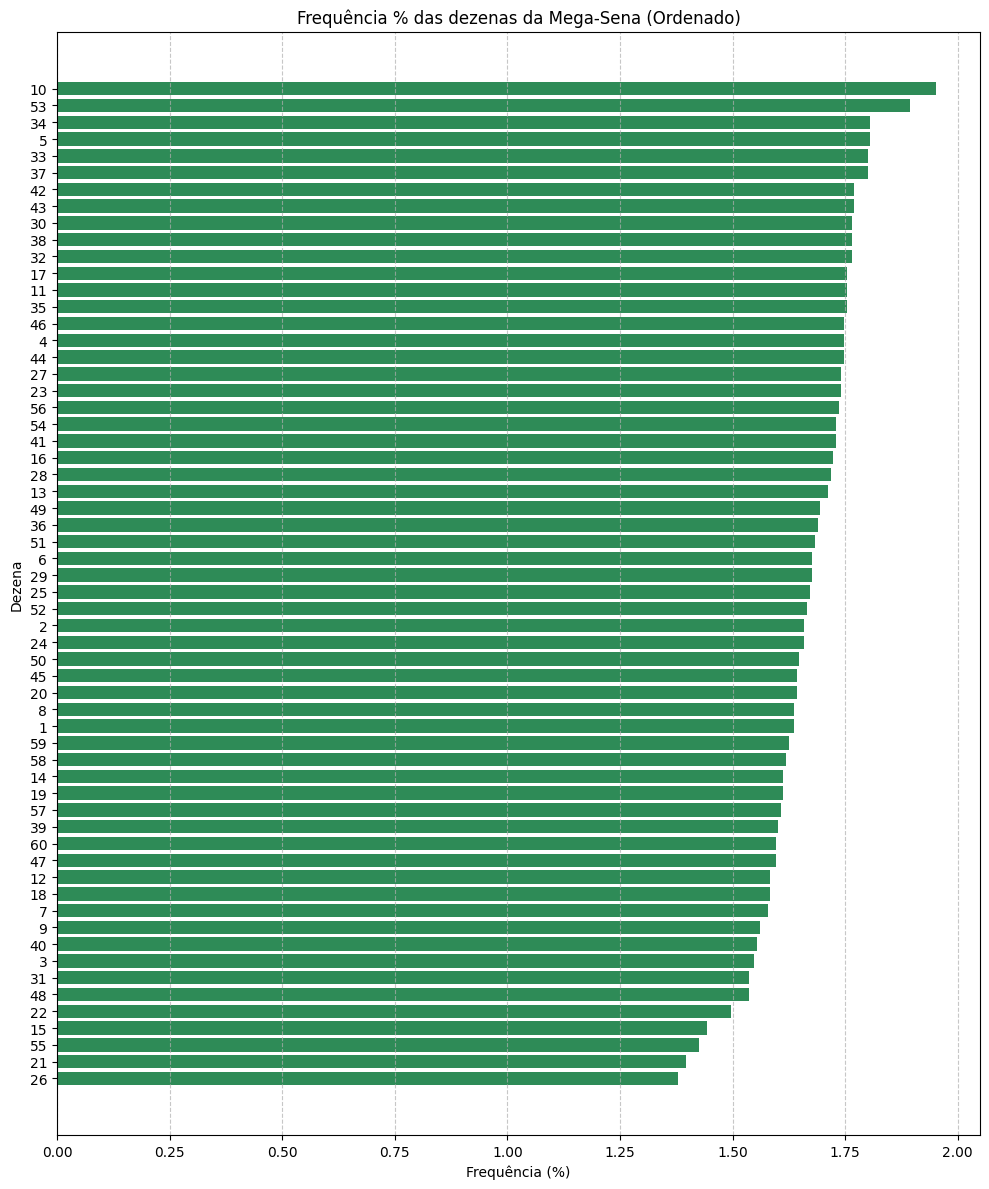

In [ ]:
import matplotlib.pyplot as plt

# Junta todas as bolas em uma série única
todos_numeros = pd.concat([
    df['Bola1'], df['Bola2'], df['Bola3'],
    df['Bola4'], df['Bola5'], df['Bola6']
])

# Conta a frequência e ordena do maior pro menor
frequencia = todos_numeros.value_counts().sort_values(ascending=False)

# Garante que o índice seja int (dezenas)
frequencia.index = frequencia.index.astype(int)

# Converte em porcentagem
frequencia_percentual = (frequencia / frequencia.sum()) * 100

# Reordena com base no valor novamente (só pra garantir)
frequencia_percentual = frequencia_percentual.sort_values(ascending=False)

# Plotando
plt.figure(figsize=(10, 12))
plt.barh(frequencia_percentual.index.astype(str), frequencia_percentual.values, color='seagreen')
plt.xlabel('Frequência (%)')
plt.ylabel('Dezena')
plt.title('Frequência % das dezenas da Mega-Sena (Ordenado)')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Palpite gerado pelo modelo
palpite_modelo = [ 9, 18, 27, 36, 44, 53]

# Junta todas as bolas em uma série única e conta frequência
todos_numeros = pd.concat([
    df['Bola1'], df['Bola2'], df['Bola3'],
    df['Bola4'], df['Bola5'], df['Bola6']
])
frequencia = todos_numeros.value_counts()
frequencia.index = frequencia.index.astype(int)
frequencia_percentual = (frequencia / frequencia.sum()) * 100

# Aplica score aos palpites com base na frequência histórica
palpite_ajustado = sorted(palpite_modelo, key=lambda x: -frequencia_percentual.get(x, 0))

# Exibe com os scores
print("\n📊 Palpite ajustado com base na frequência histórica:")
for dezena in palpite_ajustado:
    freq = frequencia_percentual.get(dezena, 0)
    print(f"Dezena {dezena:02d} - {freq:.2f}%")

print(f"\n✅ Palpite final ajustado: {palpite_ajustado}")



📊 Palpite ajustado com base na frequência histórica:
Dezena 53 - 1.89%
Dezena 44 - 1.75%
Dezena 27 - 1.74%
Dezena 36 - 1.69%
Dezena 18 - 1.58%
Dezena 09 - 1.56%

✅ Palpite final ajustado: [53, 44, 27, 36, 18, 9]
